## Model median cost/watt as function of three features: time (weeks), size_group, state

### Exclude one-hot encoded categorical from polynomial expansion.

### Summary of results

Looking for stronger $R^2$ with better noise rejection by the weekly mean. 

###  transform the data

Compute the median of cost/watt, grouped by time, size_group and state.

In [1]:
import datetime

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 8))
np.set_printoptions(precision=4, suppress=False)
# please show all columns
pd.set_option("display.max_columns", 60)
import seaborn as sns
sns.set()

In [3]:
# Import sklearn stuff

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [4]:
# load up
dfMod = pd.read_csv('../local/data/LBNL_openpv_tts_data/model_data_2.csv',
                    encoding='iso-8859-1', # avoids windows encoding issue
                    index_col='row_id',
                    parse_dates=['install_date'])

In [5]:
dfMod.head()

,num_days,num_weeks,num_months,size_kw,scaleSize,state,cost_per_watt,install_date
row_id,,,,,,,,
1,0.0,0.0,0.0,2.2824,0.0,CA,10.734315,1998-01-09
2,21.0,3.0,0.0,1.8504,0.0,CA,11.108701,1998-01-30
4,26.0,4.0,1.0,2.3076,0.0,CA,8.667013,1998-02-04
6,84.0,12.0,3.0,2.3316,0.0,CA,13.270286,1998-04-03
7,111.0,16.0,3.0,0.9300,0.0,CA,14.654839,1998-04-30


### Check that I can pull month and year from install date

In [6]:
Epoch = dfMod.iloc[0]['install_date']; Epoch

Timestamp('1998-01-09 00:00:00')

In [7]:
Epoch.year, Epoch.month, Epoch.day

(1998, 1, 9)

### Now that we have three variables, visualization requires a little more ingenuity.  See ../story/tts_story_01.ipynb for graphical representation.

### Model with median of each day's data.

Get the median for each state before modeling. Group, take the median over day, size and state.  Then reshape and encode for modeling.

In [8]:
MedByWeek = dfMod.groupby(['num_weeks', 'scaleSize', 'state'])['cost_per_watt'].median()

In [9]:
### take a look
MedByWeek.head()

num_weeks  scaleSize  state
0.0        0.0        CA       10.734315
3.0        0.0        CA       11.108701
4.0        0.0        CA        8.667013
12.0       0.0        CA       13.270286
16.0       0.0        CA       14.654839
Name: cost_per_watt, dtype: float64

In [10]:
dfMedByWeek = MedByWeek.reset_index(); dfMedByWeek.head()

,num_weeks,scaleSize,state,cost_per_watt
0,0.0,0.0,CA,10.734315
1,3.0,0.0,CA,11.108701
2,4.0,0.0,CA,8.667013
3,12.0,0.0,CA,13.270286
4,16.0,0.0,CA,14.654839


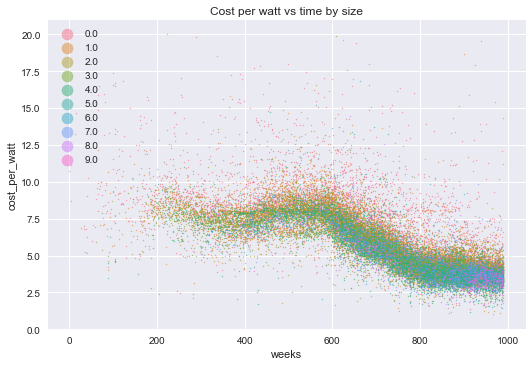

In [11]:
g = sns.FacetGrid(dfMedByWeek, hue='scaleSize', size=5, aspect=1.5)
g.map(plt.scatter, 'num_weeks', 'cost_per_watt', s=5, marker='.', alpha=0.5)
g.ax.set(xlabel='weeks',
         ylabel='cost_per_watt',
         title='Cost per watt vs time by size')
g.ax.legend(markerscale=10);

In [12]:
dfMedByWeek.state.value_counts()[:5]

CA    6189
AZ    3466
NY    3398
MA    2592
TX    2313
Name: state, dtype: int64

### Quick graph of cost vs. time in five biggest states, by size

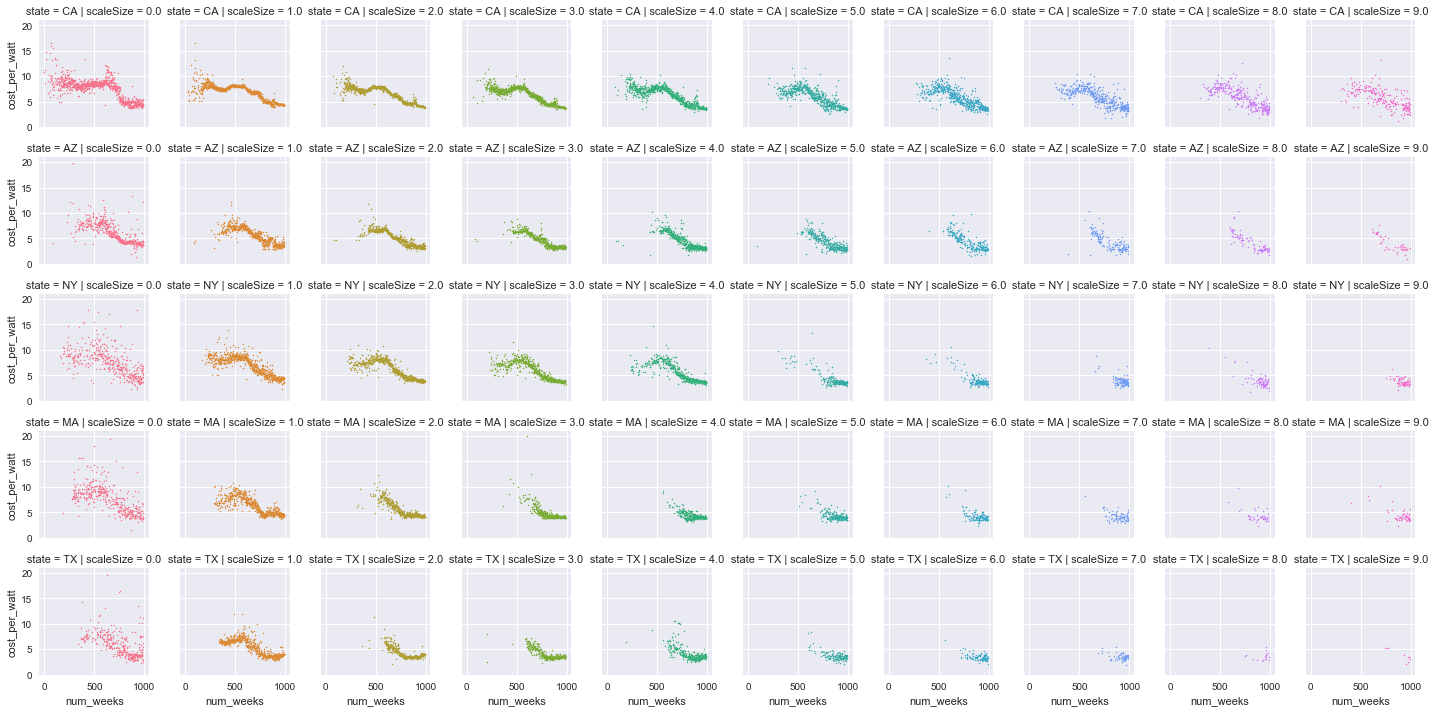

In [13]:
g = sns.FacetGrid(dfMedByWeek[dfMedByWeek.state.isin(['CA', 'AZ', 'NY', 'MA', 'TX'])], 
                  col='scaleSize', row='state', hue='scaleSize', size=2)
g.map(plt.scatter, 'num_weeks', 'cost_per_watt', marker='.', s=5);

---

### Encode and get the right shapes

In [14]:
dfModWeek = pd.get_dummies(dfMedByWeek, drop_first=True); dfModWeek.head()

,num_weeks,scaleSize,cost_per_watt,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.0,0.0,10.734315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3.0,0.0,11.108701,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.0,0.0,8.667013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,12.0,0.0,13.270286,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,16.0,0.0,14.654839,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
dfModWeek.columns

Index(['num_weeks', 'scaleSize', 'cost_per_watt', 'state_AZ', 'state_CA',
       'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR',
       'state_PA', 'state_TX', 'state_VT', 'state_WI'],
      dtype='object')

### Okay, model away

In [16]:
X = dfModWeek.drop(['cost_per_watt'], axis='columns')
y = dfModWeek[['cost_per_watt']]

X.shape, y.shape

((32548, 20), (32548, 1))

In [17]:
X.iloc[0,:]

num_weeks    0.0
scaleSize    0.0
state_AZ     0.0
state_CA     1.0
state_CT     0.0
state_DE     0.0
state_FL     0.0
state_MA     0.0
state_MD     0.0
state_MN     0.0
state_NH     0.0
state_NJ     0.0
state_NM     0.0
state_NV     0.0
state_NY     0.0
state_OR     0.0
state_PA     0.0
state_TX     0.0
state_VT     0.0
state_WI     0.0
Name: 0, dtype: float64

In [18]:
# # Setup the pipeline steps
# steps = [('scaler', StandardScaler()),
#          ('poly', PolynomialFeatures()),
#          ('LR', LinearRegression())]

# # Create the pipeline: pipeline 
# pipeline = Pipeline(steps)

### Make a pipeline that will polyexpand without including one-hot encoded vars

In [19]:
### make it an estimator and a transformer for general use
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

In [20]:
theStates = ['state_AZ', 'state_CA',
       'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR',
       'state_PA', 'state_TX', 'state_VT', 'state_WI']

In [21]:
# add LR to the pipeline
# take the data apart; numerical vars get scaled, then go to polynomial; state dummies pass through; 
# they get glued back together for the regression.
pipeline = Pipeline([
    ('features', 
     FeatureUnion([('num_vars', 
                    Pipeline([('extract', ColumnExtractor(columns=['num_weeks', 'scaleSize'])) ,
                              ('scale', StandardScaler()),
                              ('poly', PolynomialFeatures())
                              ])),
                   ('cat_vars',
                    ColumnExtractor(columns=theStates))
                  ]) # end of FeatureUnion
    ),
    ('LR', LinearRegression())
]) # end of Pipeline

In [22]:
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'features', 'LR', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__num_vars', 'features__cat_vars', 'features__num_vars__memory', 'features__num_vars__steps', 'features__num_vars__extract', 'features__num_vars__scale', 'features__num_vars__poly', 'features__num_vars__extract__columns', 'features__num_vars__scale__copy', 'features__num_vars__scale__with_mean', 'features__num_vars__scale__with_std', 'features__num_vars__poly__degree', 'features__num_vars__poly__include_bias', 'features__num_vars__poly__interaction_only', 'features__cat_vars__columns', 'LR__copy_X', 'LR__fit_intercept', 'LR__n_jobs', 'LR__normalize'])

In [23]:
# want to plot both R2 and RMSE
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Create the hyperparameter grid, just poly degree
poly_space = np.arange(1, 10)
param_grid = {'features__num_vars__poly__degree': poly_space}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=21)

# build the scoring map
scoring = {'Rsquared': 'r2',
           'RMSE': make_scorer(RMSE, greater_is_better=False) }

# Create the GridSearchCV object: gs_cv
gs_cv = GridSearchCV(pipeline, param_grid, cv=3, scoring=scoring, 
                     return_train_score=True, refit='Rsquared', verbose=1)

# Fit to the training set
gs_cv.fit(X_train, y_train)

# Compute and print the metrics
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("test R squared: {}".format(theR2))

# uncomment to see results ds
# gs_cv.cv_results_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'features__num_vars__poly__degree': 8}
test R squared: 0.7205177132573299


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    2.2s finished


#### These are fairly big errors to go along with not very impressive $R^2$.  Again we see decided leveling off at poly degree 4.

In [24]:
gs_cv.cv_results_['mean_test_RMSE'], gs_cv.cv_results_['mean_test_Rsquared']

(array([-1.319 , -1.23  , -1.1966, -1.1417, -1.1422, -1.1187, -1.1176,
        -1.1154, -1.1167]),
 array([0.6066, 0.6579, 0.6762, 0.7052, 0.7049, 0.717 , 0.7176, 0.7186,
        0.718 ]))

Best parameters: {'features__num_vars__poly__degree': 8}
Best R squared: 0.7205177132573299


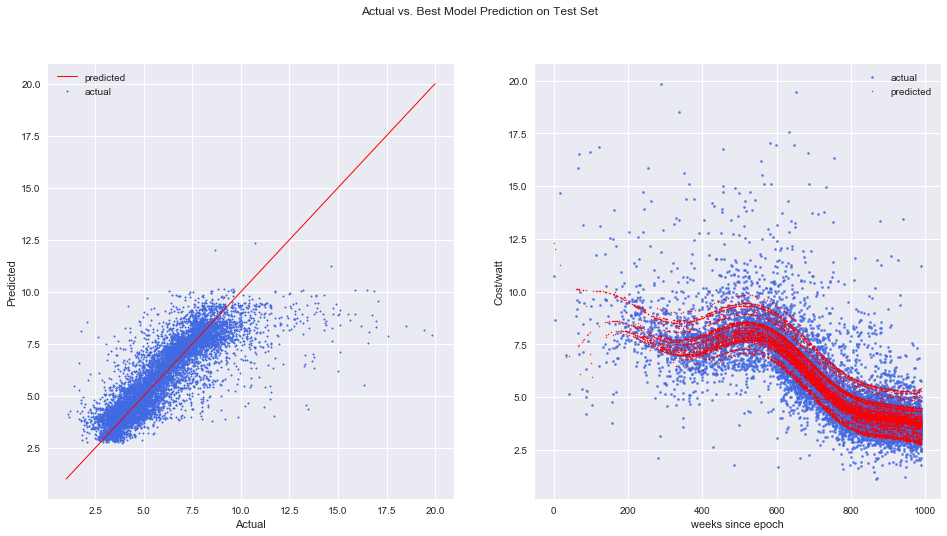

In [25]:
# Show R2
theR2 = gs_cv.score(X_test, y_test)
print("Best parameters: {}".format(gs_cv.best_params_))
print("Best R squared: {}".format(theR2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Actual vs. Best Model Prediction on Test Set')

ax1.scatter(y_test, gs_cv.predict(X_test), marker='.', s=10, color='royalblue', alpha=1, label='actual')
ax1.plot(np.array([1,20]), np.array([1,20]), linewidth=1, color='red', label='predicted')
ax1.set_ylabel('Predicted')
ax1.set_xlabel('Actual')
ax1.legend()

ax2.scatter(X_test['num_weeks'], y_test, marker='.', color='royalblue', s=20, alpha=0.9, label='actual')
ax2.scatter(X_test['num_weeks'], gs_cv.predict(X_test), marker='.', color='red', s=5, alpha=.8, label='predicted')
ax2.set_ylabel('Cost/watt')
ax2.set_xlabel('weeks since epoch')
ax2.legend()

plt.show();

### Extrapolate with best model

#### Strategy for building X to extrapolate

Make a prediction X like in previous model.  

Just use 3 (maybe 5) states.   Then build a number_of(state cols) wide matrix with the same number of rows as X.  Then glue them together.

Or could do 3 (5) separate Xs done the same way.  That way the predictions could be plotted in different colors.

The good news is this can be reused when I redo this without poly expanding the states.


### just build california to start

#### Build an X with scaleSize 5; now, though the X and y are pd.Dataframe (for feature processing) so my predictor matrix needs to be one too.  

The easiest way is to build np.array, shove into df and add the column names

In [26]:
# the last week
X.iloc[-1,0]

990.0

In [27]:
# number of weeks; plot every quarter; add 102 weeks 
x1 = np.linspace(0.0, 1094, int(1094/13)); x1.shape
# set scaleSize to 5
x2 = np.zeros(int(1094/13)); x2[:] = 5.0
X_future = np.stack([x1, x2], axis=-1); X_future.shape

(84, 2)

In [28]:
# build a matrix for state columns
state_CA = np.zeros((84, 18)); state_CA.shape

(84, 18)

In [29]:
# set CA
state_CA[:, 1] = 1.0; 

# show me a couple of rows
state_CA[:2,:]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

In [30]:
X_CA_s5 = np.concatenate([X_future, state_CA], axis=1); X_CA_s5.shape

(84, 20)

In [31]:
dfX_CA_s5 = pd.DataFrame(X_CA_s5, columns=['num_weeks', 'scaleSize', 'state_AZ', 'state_CA',
       'state_CT', 'state_DE', 'state_FL', 'state_MA', 'state_MD', 'state_MN',
       'state_NH', 'state_NJ', 'state_NM', 'state_NV', 'state_NY', 'state_OR',
       'state_PA', 'state_TX', 'state_VT', 'state_WI'])

In [32]:
dfX_CA_s5.head()

,num_weeks,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.000000,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.180723,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.361446,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39.542169,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.722892,5.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
gs_cv.predict(dfX_CA_s5).shape

(84, 1)

### Okay, that's the right shape; now build some others.

In [34]:
dfX_CA_s1 = dfX_CA_s5.copy()
dfX_CA_s1.loc[:, 'scaleSize'] = 1

In [35]:
dfX_CA_s9 = dfX_CA_s5.copy()
dfX_CA_s9.loc[:, 'scaleSize'] = 9

In [36]:
dfX_CA_s1.head()

,num_weeks,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.000000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.180723,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.361446,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39.542169,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.722892,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
dfX_CA_s9.head()

,num_weeks,scaleSize,state_AZ,state_CA,state_CT,state_DE,state_FL,state_MA,state_MD,state_MN,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OR,state_PA,state_TX,state_VT,state_WI
0,0.000000,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.180723,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,26.361446,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,39.542169,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,52.722892,9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
dfTX_s5 = dfX_CA_s5.copy()
dfTX_s5.loc[:, 'state_CA'] = 0
dfTX_s5.loc[:, 'state_TX'] = 1

In [39]:
dfTX_s1 = dfX_CA_s1.copy()
dfTX_s1.loc[:, 'state_CA'] = 0
dfTX_s1.loc[:, 'state_TX'] = 1

In [40]:
dfTX_s9 = dfX_CA_s9.copy()
dfTX_s9.loc[:, 'state_CA'] = 0
dfTX_s9.loc[:, 'state_TX'] = 1

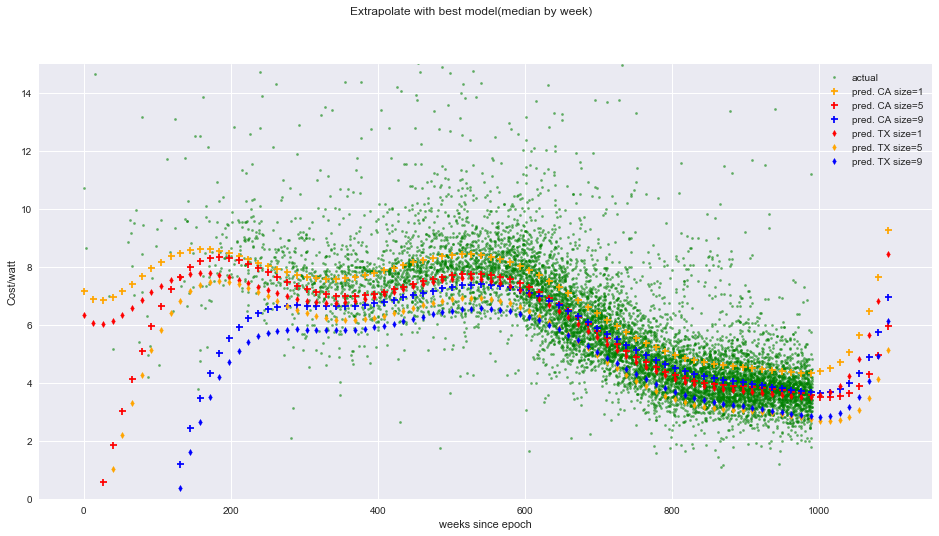

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.suptitle('Extrapolate with best model(median by week)')

ax.scatter(X_test['num_weeks'], y_test, marker='.', color='green', s=20, alpha=0.6, label='actual')

ax.scatter(dfX_CA_s1['num_weeks'], gs_cv.predict(dfX_CA_s1), marker='+', 
           color='orange', alpha=1, label='pred. CA size=1')
ax.scatter(dfX_CA_s5['num_weeks'], gs_cv.predict(dfX_CA_s5), marker='+', 
           color='red', alpha=1, label='pred. CA size=5')
ax.scatter(dfX_CA_s9['num_weeks'], gs_cv.predict(dfX_CA_s9), marker='+', 
           color='blue', alpha=1, label='pred. CA size=9')

ax.scatter(dfTX_s1['num_weeks'], gs_cv.predict(dfTX_s1), marker='d', 
           color='red', s=20, alpha=1, label='pred. TX size=1')
ax.scatter(dfTX_s5['num_weeks'], gs_cv.predict(dfTX_s5), marker='d', 
           color='orange', s=20, alpha=1, label='pred. TX size=5')
ax.scatter(dfTX_s9['num_weeks'], gs_cv.predict(dfTX_s9), marker='d', 
           color='blue', s=20, alpha=1, label='pred. TX size=9')
ax.set_ylabel('Cost/watt')
ax.set_xlabel('weeks since epoch')
ax.set_ylim(0,15)
ax.legend();

#### Okay fit, poor predictions.  Reducing polynomial degree improves predictions with very little reduction of $R^2$ (see train/test vs poly degree plot below).

In [42]:
def trainVsTestResults(results): 
    ''' Plot test/train results for R^2 and RMSE'''    

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    sTitle = 'mean cross-validation train/test RMSE and R^2 vs poly degree'
    fig.suptitle(sTitle)
          
    mean_train_RMSE = results['mean_train_RMSE']
    mean_test_RMSE = results['mean_test_RMSE']
    n = len(mean_train_RMSE)
        
    ax1.plot(np.arange(1, n + 1), np.abs(mean_train_RMSE), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax1.plot(np.arange(1, n + 1), np.abs(mean_test_RMSE), marker='*', ms=10, alpha=1.0, color='red', label='test');
    ax1.set_ylabel('RMSE')
    ax1.set_xlabel('polynomial degree')
    ax1.set_title('mean train/test RMSE vs poly degree')
    ax1.set_ylim(0, 1.5)
    ax1.legend()
    
    mean_train_R2 = results['mean_train_Rsquared']
    mean_test_R2 = results['mean_test_Rsquared']
    n = len(mean_train_R2)
    
    fig.suptitle(sTitle.format(gs_cv.best_params_))

    ax2.plot(np.arange(1, n + 1), np.abs(mean_train_R2), marker='d', ms=15, alpha=0.5, color='green', label='train');
    ax2.plot(np.arange(1, n + 1), np.abs(mean_test_R2), marker='*', ms=10, color='red', label='test');
    ax2.set_ylabel('R^2')
    ax2.set_xlabel('polynomial degree')
    ax2.set_title('mean train/test R2 vs poly degree')
    ax2.set_ylim(0, 1)
    ax2.legend()
          
    r2 = gs_cv.score(X_test, y_test)
    print("Best parameters: {}".format(gs_cv.best_params_))
    print("Best parameters test R squared: {}".format(r2))

Best parameters: {'features__num_vars__poly__degree': 8}
Best parameters test R squared: 0.7205177132573299


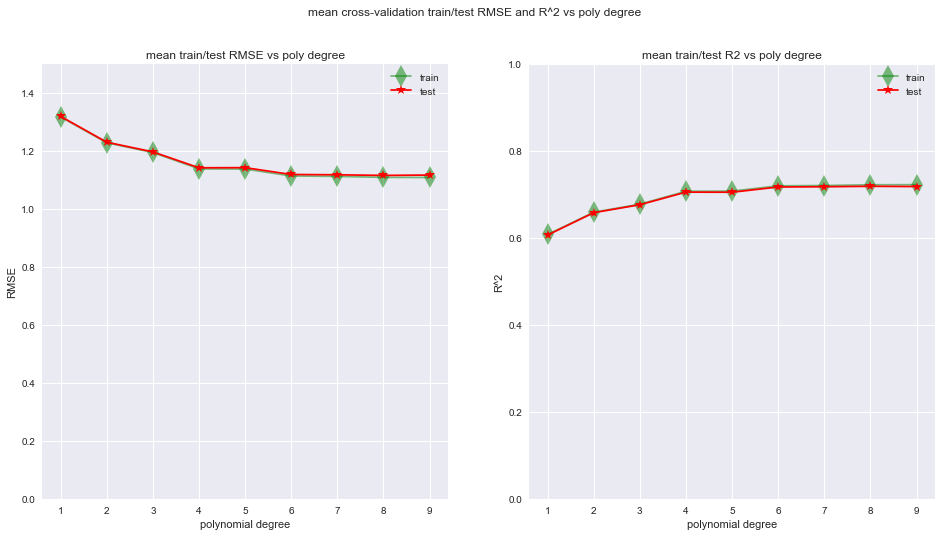

In [43]:
trainVsTestResults(gs_cv.cv_results_)

### 3rd degree model of weekly median (week, size, state)

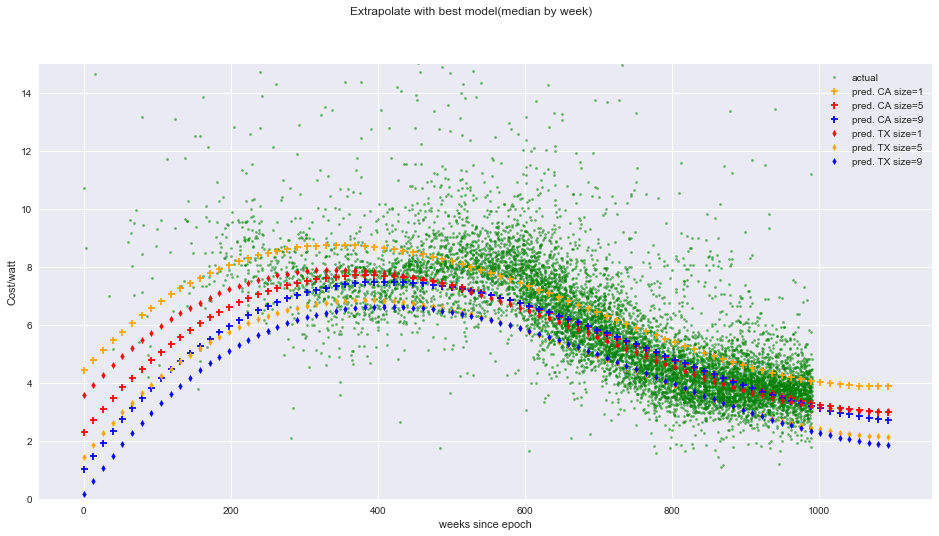

### 7th degree model of weekly median (week, size, state)
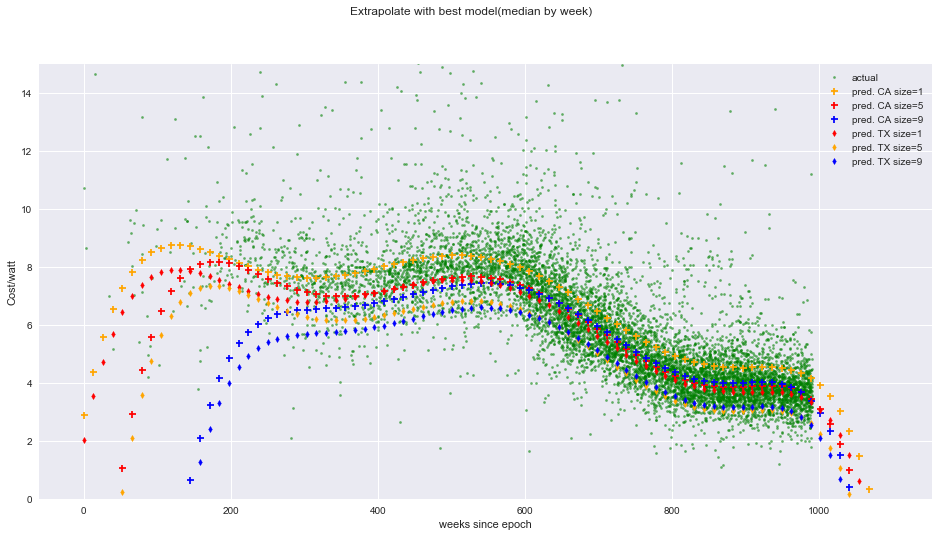

### 6th degree model of weekly median (week, size, state)

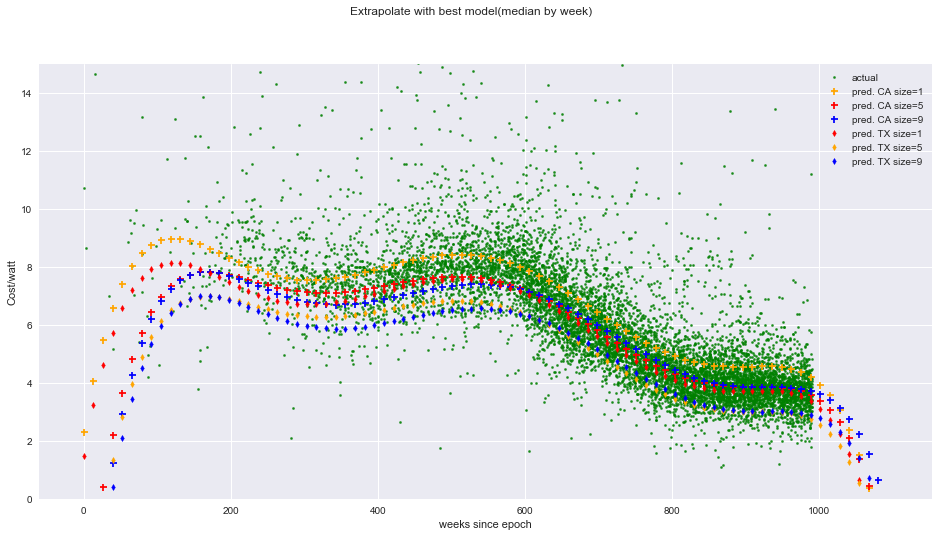

### 5th degree model of weekly median (week, size, state)

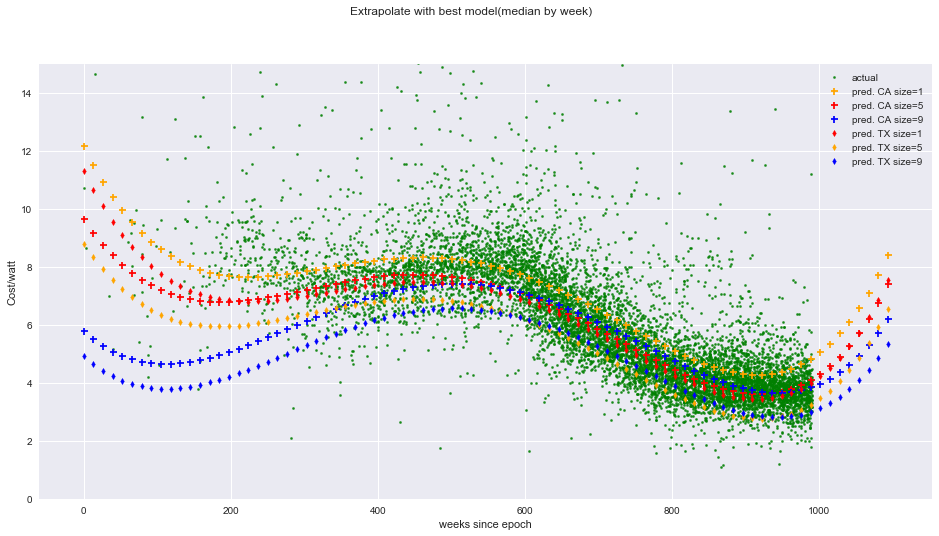


### 4th degree model of weekly median (week, size, state)
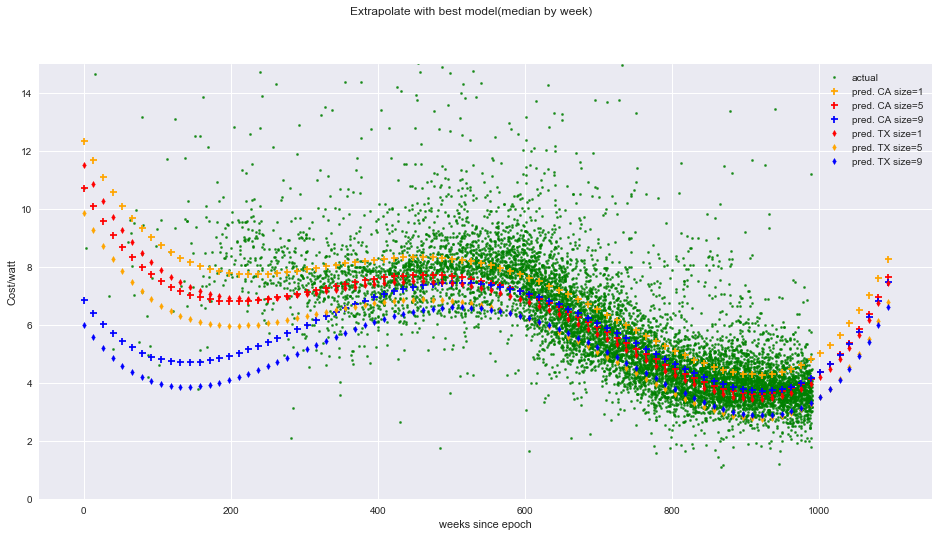